In [19]:
from helpers import *
from dataset import *
from model2_for48 import *
from czii_helper import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import random
import torchvision.transforms as T
import cv2
import math
import cc3d
from torch.utils.data import Dataset, DataLoader
from monai.transforms import Compose, NormalizeIntensityd, ToTensorD
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import precision_score, recall_score, f1_score
from monai.transforms import RandFlipd,RandRotated,RandZoomd,RandAffined,ResizeD,SpatialPadd,RandRotate90d,EnsureChannelFirstd,Orientationd,RandAdjustContrastd,RandGaussianNoised

In [20]:
DEBAG = False
#DEBAG = True

In [21]:
MODE = 'local'
valid_dir = '../input/czii-cryo-et-object-identification/train'

cfg = dotdict(
    arch ='resnet34d',
    checkpoint=\
    '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00010164-extern.pth',
   # '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-aug-noise-00003956.pth',
       #  '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00002300.pth',
       # '/kaggle/input/hengck-czii-cryo-et-weights-01/00003531.pth',
    threshold={ 
        'apo-ferritin': 0.05,
        'beta-amylase': 0.05,
        'beta-galactosidase': 0.05,
        'ribosome': 0.05,
        'thyroglobulin': 0.05,
        'virus-like-particle': 0.05,
    }, 
)

In [ ]:
mask_size2 = {
    'defolt': 1,
    'apo-ferritin': mask_size["apo-ferritin"]*0.8,
    'beta-amylase':0,
    'beta-galactosidase': mask_size["beta-galactosidase"]*0.8,
    'ribosome': mask_size["ribosome"]*0.8,
    'thyroglobulin': mask_size["thyroglobulin"]*0.8,
    'virus-like-particle': mask_size["virus-like-particle"]*0.8,
}
print(mask_size2)
mask_check("TS_5_4",mask_size2,cfg)

{'defolt': 1, 'apo-ferritin': 4.800000000000001, 'beta-amylase': 0, 'beta-galactosidase': 7.2, 'ribosome': 12.0, 'thyroglobulin': 10.4, 'virus-like-particle': 10.8}


(5, 184, 630, 630)
(5, 184, 630, 630)


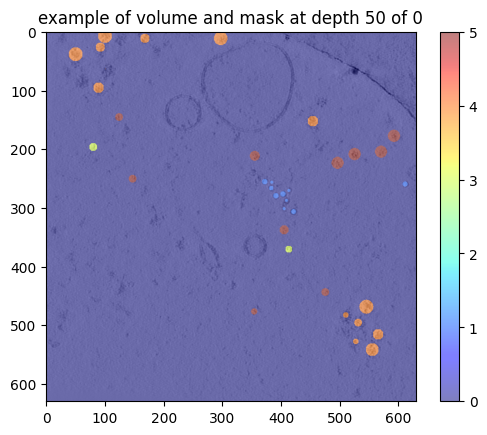

In [5]:
train_dir = '../input/czii-cryo-et-object-identification/train/static/ExperimentRuns/'
mask_dir = '../input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/'

#diff =["denoised","isonetcorrected","wbp","ctfdeconvolved"]
#diff =["denoised","isonetcorrected","wbp","ctfdeconvolved","denoised"]
diff =["denoised"]

valid_id = ["TS_6_4", "TS_6_6", "TS_69_2", "TS_73_6", "TS_86_3"]
if DEBAG:
    valid_id = ["TS_5_4"]
test_id = ["TS_5_4",'TS_99_9',]

volumes = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.float32)
masks = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.uint8)

n = 0
for idx in range(len(valid_id)):
    for diff_type in diff:
        data = read_diff_data(valid_id[idx], train_dir, diff_type)
        data = data.astype(np.float32)
        volumes[n, :, :, :] = data

        y = read_one_truth(valid_id[idx], f'{valid_dir}/overlay/ExperimentRuns')
        mask_data = generate_mask(y, mask_size2)
        mask_data = mask_data.astype(np.uint8)
        masks[n, :, :, :] = mask_data
        n += 1
print(volumes.shape)
print(masks.shape)

print_slices(volumes, masks,dim=4,idx=0,depth=50)

In [6]:
class VolumeDatasetSlices(Dataset):
    def __init__(self, vol_data, mask_data, patch_size=32, stride=16, transform=None):
        """
        Args:
            vol_data (numpy.ndarray): 形状 (N, D, H, W) を想定 (例: (N, 184, 640, 640))
            mask_data (numpy.ndarray): 形状 (N, D, H, W) を想定 (例: (N, 184, 640, 640))
            patch_size (int): 切り出したい深さ方向のスライス数 (例: 32)
            stride (int): スライドウィンドウの移動量 (例: 16)
            transform (callable, optional): MONAIの辞書ベースTransformsなど
        """
        self.vol_data = vol_data
        self.mask_data = mask_data
        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform

        self.indices = []
        # 全サンプルに対してスライスの開始・終了位置をまとめる
        for idx in range(len(vol_data)):
            d = vol_data[idx].shape[0]  # 深さ(D次元)の大きさ
            # 0, stride, 2*stride, ... のように動かしながら、patch_sizeぶん取り出せる範囲でスライス
            for start in range(0, d - patch_size + 1, stride):
                #ランダムに動かす
                start = start 
                end = start + patch_size
                # (サンプル番号, スライス開始, スライス終了) を記録
                #マスクが含まれるスライスのみを記録
                if np.sum(mask_data[idx][start:end]) >= 0:
                    self.indices.append((idx, start, end))
            start = d - patch_size
            end = d
            if np.sum(mask_data[idx][start:end]) >= 0:
                self.indices.append((idx, start, end))


    def __len__(self):
        # スライスの総数を返す
        return len(self.indices)

    def __getitem__(self, i):
        idx, start, end = self.indices[i]

        # （idx番目のボリューム・マスク） のうち, 深さ方向を [start:end] で切り出す
        volume = self.vol_data[idx][start:end]  # (patch_size, H, W)
        mask   = self.mask_data[idx][start:end] # (patch_size, H, W)

        data_dict = {"image": volume, "label": mask}
        if self.transform:
            data_dict = self.transform(data_dict)

        return data_dict["image"], data_dict["label"]

# --- 使い方の例 ---

# 変換の定義
# ToTensorD で numpy -> torch.Tensor に変換し、さらに正規化を行う
transforms = Compose([
    # 1. Tensor形式に変換
    ToTensorD(keys=["image", "label"]),
    
    # 2. チャンネルの次元を先頭に移動
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    
    # 3. データをRAS方向に揃える
    Orientationd(keys=["image", "label"], axcodes="RAS"),
        
    # 4. ランダム90度回転を適用
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1, 2]),
    
    # 5. ランダム反転 (空間軸 0 に沿って)
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    
    # 6. パディングを適用して (32, 640, 640) に拡張
    SpatialPadd(keys=["image", "label"], spatial_size=(32, 640, 640), mode="constant", method="end"),
    
])


In [7]:
dataset = VolumeDatasetSlices(
    vol_data=volumes, 
    mask_data=masks, 
    patch_size=32, 
    stride=16,
    transform=transforms
)
raw_dataset = VolumeDatasetSlices(
    vol_data=volumes, 
    mask_data=masks, 
    patch_size=32, 
    stride=16,
    transform=None
)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
no_transform_dataloader = DataLoader(raw_dataset, batch_size=1, shuffle=True)
# データを取り出す
#i = 0
#print(len(dataloader))  # 6
#for volume, mask in dataloader:
#    i += 1
#    print(volume.shape, mask.shape)  # torch.Size([1, 32, 640, 640]) torch.Size([1, 32, 640, 640])
#    print_slices(volume[0], mask[0], dim=3, idx=0, depth=16)
#    if i == 3:
#        break

55
torch.Size([1, 1, 32, 640, 640]) torch.Size([1, 1, 32, 640, 640])


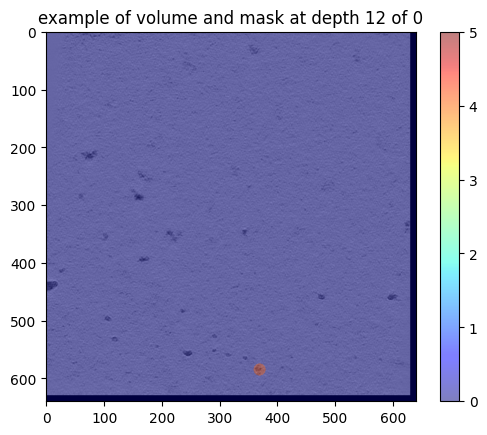

38595
torch.Size([1, 1, 32, 640, 640]) torch.Size([1, 1, 32, 640, 640])


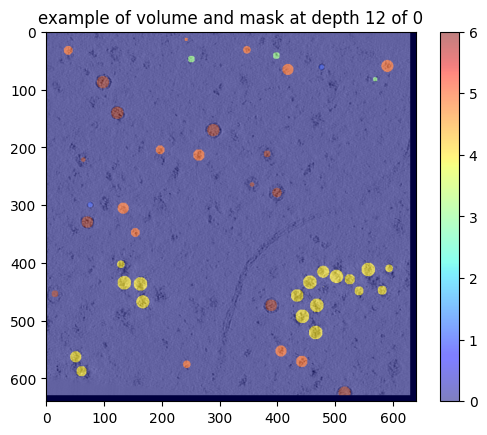

1752907


In [8]:
 #データを取り出す
i = 0
print(len(dataloader))  # 6
for volume, mask in dataloader:
    i += 1
    print(volume.shape, mask.shape)  # torch.Size([1, 32, 640, 640]) torch.Size([1, 32, 640, 640])
    print_slices(volume[0], mask[0], dim=4, idx=0, depth=12)
    #print_volume_slices(mask[0], dim=4, idx=0, depth=12)
    print(np.sum(mask[0].numpy()))
    if i == 2:
        break

In [9]:
GPU_ID = 2
device = torch.device(f'cuda:{GPU_ID}' if torch.cuda.is_available() else 'cpu')
print(device)
net = Net(pretrained=False,cfg=None).to(device)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

cuda:2


In [10]:
global train_batch, test_batch

In [11]:
from torch.optim.lr_scheduler import LambdaLR
from IPython.display import clear_output
from tqdm import tqdm

# 学習ループにCV計算を追加
num_epochs = 50
learning_rate = 1e-3
accumulation_steps = 4  # 勾配を累積するステップ数

optimizer = torch.optim.AdamW(
    net.parameters(),
    amsgrad=False,
    betas=(0.9, 0.999),
    capturable=False,
    differentiable=False,
    eps=1e-08,
    foreach=None,
    fused=None,
    lr=learning_rate,
    weight_decay=0.01
)

warmup_steps = 30
total_steps = num_epochs * len(dataloader)

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))  # 線形ウォームアップ
    return 0.5 * (1. + np.cos(np.pi * (current_step - warmup_steps) / (total_steps - warmup_steps)))

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

scaler = torch.cuda.amp.GradScaler(init_scale=4096)

epoch_losses = []
cv_scores = []  # CVスコアの記録リスト
mask_losses = []

global_step = 0

for epoch in tqdm(range(num_epochs)):
    if False:  # epoch % 5 == 0 を無効化
        optimizer = torch.optim.AdamW(
            net.parameters(),
            amsgrad=False,
            betas=(0.9, 0.999),
            capturable=False,
            differentiable=False,
            eps=1e-08,
            foreach=None,
            fused=None,
            lr=learning_rate,
            weight_decay=0.01
        )

    print(f"エポック {epoch + 1}/{num_epochs}")
    print("-" * 10)

    net.train()
    running_loss = 0.0

    for i, (volumes, masks) in enumerate(dataloader):
        # 1次元削減
        volumes = volumes.squeeze(0)
        masks = masks.squeeze(0)

        batch, D, H, W = volumes.shape

        if np.sum(masks) == 0:
            continue
        batch = {
            'image': volumes.to(device).float(),
            'mask': masks.to(device).long(),
        }

        optimizer.zero_grad(set_to_none=True) if i % accumulation_steps == 0 else None

        with torch.amp.autocast(device_type="cuda", enabled=True):
            output = net(batch)
            loss = output['mask_loss'] / accumulation_steps  # 累積ステップ数でスケーリング

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(dataloader):
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            global_step += 1

        running_loss += loss.item() * accumulation_steps  # スケーリングを戻して加算

    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"train_loss: {epoch_loss:.4f}")
    # 15エポックごとにCVスコアを計算
    if  epoch  % 1 == 0:
        gb, lb_score, mask_loss,probability = evaluate_cv(net, test_id, cfg, valid_dir, device, mask_size2)
        print(f"valid_loss: {np.mean(mask_loss):.4f}")
        print(f"CVスコア {lb_score:.4f}")  # test_id: 検証用データIDリスト
        print(gb[["particle_type", "P", "T", "hit", "precision", "recall", "f-beta4"]])
    cv_scores.append(lb_score)
    #lbスコアが最大のモデルを保存
    if lb_score == max(cv_scores):
        torch.save({'state_dict': net.state_dict()}, '../model/resnet34d.pth')
    mask_losses.append(np.mean(mask_loss))

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  0%|          | 0/50 [00:00<?, ?it/s]

エポック 1/50
----------
train_loss: 1.4484
valid_loss: 1.6727
CVスコア 0.0000
         particle_type    P   T  hit  precision  recall  f-beta4
0         apo-ferritin   46  82    0        0.0     0.0      0.0
1         beta-amylase    2  31    0        0.0     0.0      0.0
2   beta-galactosidase    2  36    0        0.0     0.0      0.0
3             ribosome  649  96    0        0.0     0.0      0.0
4        thyroglobulin    4  79    0        0.0     0.0      0.0
5  virus-like-particle    4  24    0        0.0     0.0      0.0


  2%|▏         | 1/50 [01:03<52:01, 63.71s/it]

エポック 2/50
----------
train_loss: 1.2726
valid_loss: 1.5535
CVスコア 0.0000
         particle_type    P   T  hit  precision  recall  f-beta4
0         apo-ferritin    2  82    0        0.0     0.0      0.0
1         beta-amylase  108  31    0        0.0     0.0      0.0
2   beta-galactosidase    4  36    0        0.0     0.0      0.0
3             ribosome    2  96    0        0.0     0.0      0.0
4        thyroglobulin    2  79    0        0.0     0.0      0.0
5  virus-like-particle    2  24    0        0.0     0.0      0.0


  4%|▍         | 2/50 [02:06<50:36, 63.26s/it]

エポック 3/50
----------
train_loss: 1.1647
valid_loss: 1.4960
CVスコア 0.0000
         particle_type    P   T  hit  precision  recall  f-beta4
0         apo-ferritin    2  82    0        0.0     0.0      0.0
1         beta-amylase  402  31    0        0.0     0.0      0.0
2   beta-galactosidase    2  36    0        0.0     0.0      0.0
3             ribosome    2  96    0        0.0     0.0      0.0
4        thyroglobulin    2  79    0        0.0     0.0      0.0
5  virus-like-particle    2  24    0        0.0     0.0      0.0


  6%|▌         | 3/50 [03:11<50:00, 63.83s/it]

エポック 4/50
----------
train_loss: 1.0679
valid_loss: 1.3632
CVスコア 0.0000
         particle_type    P   T  hit  precision  recall  f-beta4
0         apo-ferritin    2  82    0        0.0     0.0      0.0
1         beta-amylase  176  31    0        0.0     0.0      0.0
2   beta-galactosidase    2  36    0        0.0     0.0      0.0
3             ribosome    2  96    0        0.0     0.0      0.0
4        thyroglobulin    2  79    0        0.0     0.0      0.0
5  virus-like-particle    2  24    0        0.0     0.0      0.0


  8%|▊         | 4/50 [04:15<49:02, 63.96s/it]

エポック 5/50
----------
train_loss: 0.9642
valid_loss: 1.4585
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  2  82    0        0.0     0.0      0.0
1         beta-amylase  9  31    0        0.0     0.0      0.0
2   beta-galactosidase  2  36    0        0.0     0.0      0.0
3             ribosome  2  96    0        0.0     0.0      0.0
4        thyroglobulin  2  79    0        0.0     0.0      0.0
5  virus-like-particle  2  24    0        0.0     0.0      0.0


 10%|█         | 5/50 [05:18<47:43, 63.63s/it]

エポック 6/50
----------
train_loss: 0.8697
valid_loss: 1.2207
CVスコア 0.0000
         particle_type    P   T  hit  precision  recall  f-beta4
0         apo-ferritin    2  82    0        0.0     0.0      0.0
1         beta-amylase  161  31    0        0.0     0.0      0.0
2   beta-galactosidase    2  36    0        0.0     0.0      0.0
3             ribosome    2  96    0        0.0     0.0      0.0
4        thyroglobulin    2  79    0        0.0     0.0      0.0
5  virus-like-particle    2  24    0        0.0     0.0      0.0


 12%|█▏        | 6/50 [06:22<46:48, 63.82s/it]

エポック 7/50
----------
train_loss: 0.7676
valid_loss: 1.0464
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  2  82    0        0.0     0.0      0.0
1         beta-amylase  4  31    0        0.0     0.0      0.0
2   beta-galactosidase  2  36    0        0.0     0.0      0.0
3             ribosome  2  96    0        0.0     0.0      0.0
4        thyroglobulin  2  79    0        0.0     0.0      0.0
5  virus-like-particle  2  24    0        0.0     0.0      0.0


 14%|█▍        | 7/50 [07:25<45:37, 63.66s/it]

エポック 8/50
----------
train_loss: 0.6726
valid_loss: 0.9169
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   2  82    0        0.0     0.0      0.0
1         beta-amylase  18  31    0        0.0     0.0      0.0
2   beta-galactosidase   2  36    0        0.0     0.0      0.0
3             ribosome   2  96    0        0.0     0.0      0.0
4        thyroglobulin   2  79    0        0.0     0.0      0.0
5  virus-like-particle   2  24    0        0.0     0.0      0.0


 16%|█▌        | 8/50 [08:28<44:24, 63.44s/it]

エポック 9/50
----------
train_loss: 0.5679
valid_loss: 0.7883
CVスコア 0.0000
         particle_type    P   T  hit  precision  recall  f-beta4
0         apo-ferritin    2  82    0        0.0     0.0      0.0
1         beta-amylase   13  31    0        0.0     0.0      0.0
2   beta-galactosidase    2  36    0        0.0     0.0      0.0
3             ribosome    2  96    0        0.0     0.0      0.0
4        thyroglobulin    2  79    0        0.0     0.0      0.0
5  virus-like-particle  277  24    0        0.0     0.0      0.0


 18%|█▊        | 9/50 [09:32<43:18, 63.37s/it]

エポック 10/50
----------
train_loss: 0.4684
valid_loss: 0.7310
CVスコア 0.0000
         particle_type    P   T  hit  precision  recall  f-beta4
0         apo-ferritin  550  82    0        0.0     0.0      0.0
1         beta-amylase   98  31    0        0.0     0.0      0.0
2   beta-galactosidase    3  36    0        0.0     0.0      0.0
3             ribosome  212  96    0        0.0     0.0      0.0
4        thyroglobulin    2  79    0        0.0     0.0      0.0
5  virus-like-particle  599  24    0        0.0     0.0      0.0


 20%|██        | 10/50 [10:35<42:21, 63.53s/it]

エポック 11/50
----------
train_loss: 0.3855
valid_loss: 0.5676
CVスコア 0.0000
         particle_type    P   T  hit  precision  recall  f-beta4
0         apo-ferritin  413  82    0        0.0     0.0      0.0
1         beta-amylase    4  31    0        0.0     0.0      0.0
2   beta-galactosidase    6  36    0        0.0     0.0      0.0
3             ribosome   66  96    0        0.0     0.0      0.0
4        thyroglobulin    2  79    0        0.0     0.0      0.0
5  virus-like-particle  454  24    0        0.0     0.0      0.0


 22%|██▏       | 11/50 [11:40<41:30, 63.87s/it]

エポック 12/50
----------
train_loss: 0.3244
valid_loss: 0.4534
CVスコア 0.0000
         particle_type     P   T  hit  precision  recall  f-beta4
0         apo-ferritin  2704  82    0        0.0     0.0      0.0
1         beta-amylase  1053  31    0        0.0     0.0      0.0
2   beta-galactosidase   129  36    0        0.0     0.0      0.0
3             ribosome   693  96    0        0.0     0.0      0.0
4        thyroglobulin   444  79    0        0.0     0.0      0.0
5  virus-like-particle   530  24    0        0.0     0.0      0.0


 24%|██▍       | 12/50 [12:44<40:29, 63.94s/it]

エポック 13/50
----------
train_loss: 0.2765
valid_loss: 0.3574
CVスコア 0.0042
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin  2520  82    1   0.000397  0.012195  0.004436
1         beta-amylase  1717  31    2   0.001165  0.064516  0.015364
2   beta-galactosidase  3637  36    0   0.000000  0.000000  0.000000
3             ribosome  3858  96    4   0.001037  0.041667  0.012607
4        thyroglobulin  5191  79    1   0.000193  0.012658  0.002634
5  virus-like-particle  4436  24    2   0.000451  0.083333  0.007054


 26%|██▌       | 13/50 [13:48<39:27, 63.98s/it]

エポック 14/50
----------
train_loss: 0.2337
valid_loss: 0.3855
CVスコア 0.0057
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin  1502  82    2   0.001332  0.024390  0.012082
1         beta-amylase  1408  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  1761  36    1   0.000568  0.027778  0.007274
3             ribosome  1609  96    0   0.000000  0.000000  0.000000
4        thyroglobulin  2955  79    1   0.000338  0.012658  0.004029
5  virus-like-particle  2798  24    1   0.000357  0.041667  0.005343


 28%|██▊       | 14/50 [14:52<38:17, 63.82s/it]

エポック 15/50
----------
train_loss: 0.2040
valid_loss: 0.2998
CVスコア 0.0666
         particle_type      P   T  hit  precision    recall   f-beta4
0         apo-ferritin   2078  82    3   0.001444  0.036585  0.015044
1         beta-amylase  12829  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  38071  36   12   0.000315  0.333333  0.005279
3             ribosome   2437  96   12   0.004924  0.125000  0.051347
4        thyroglobulin   2567  79   37   0.014414  0.468354  0.164187
5  virus-like-particle   2422  24   10   0.004129  0.416667  0.060584


 30%|███       | 15/50 [15:55<37:06, 63.62s/it]

エポック 16/50
----------
train_loss: 0.1777


 32%|███▏      | 16/50 [16:56<35:40, 62.95s/it]

valid_loss: 0.3383
CVスコア 0.0113
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin  4081  82    4   0.000980  0.048780  0.012609
1         beta-amylase  2293  31    3   0.001308  0.096774  0.018286
2   beta-galactosidase  5571  36    1   0.000180  0.027778  0.002766
3             ribosome  2706  96    0   0.000000  0.000000  0.000000
4        thyroglobulin  4302  79    8   0.001860  0.101266  0.024434
5  virus-like-particle  2417  24    2   0.000827  0.083333  0.012139
エポック 17/50
----------
train_loss: 0.1545
valid_loss: 0.2376
CVスコア 0.0784
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin  2094  82    4   0.001910  0.048780  0.019965
1         beta-amylase  3041  31    2   0.000658  0.064516  0.009613
2   beta-galactosidase  1980  36    0   0.000000  0.000000  0.000000
3             ribosome  2464  96   11   0.004464  0.114583  0.046750
4        thyroglobulin  3791  79   57   0.015036  0.721519  0.19169

 34%|███▍      | 17/50 [17:59<34:33, 62.83s/it]

エポック 18/50
----------
train_loss: 0.1356


 36%|███▌      | 18/50 [18:58<32:56, 61.78s/it]

valid_loss: 0.1887
CVスコア 0.0419
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin   945  82    2   0.002116  0.024390  0.015064
1         beta-amylase   900  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   886  36    0   0.000000  0.000000  0.000000
3             ribosome  4088  96   51   0.012476  0.531250  0.154161
4        thyroglobulin  1275  79    8   0.006275  0.101266  0.053564
5  virus-like-particle   636  24    1   0.001572  0.041667  0.016667
エポック 19/50
----------
train_loss: 0.1226


 38%|███▊      | 19/50 [19:58<31:35, 61.15s/it]

valid_loss: 0.1850
CVスコア 0.0319
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin  1781  82    0   0.000000  0.000000  0.000000
1         beta-amylase   483  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   818  36    0   0.000000  0.000000  0.000000
3             ribosome  2585  96   29   0.011219  0.302083  0.119631
4        thyroglobulin  2605  79    9   0.003455  0.113924  0.039545
5  virus-like-particle  1664  24    3   0.001803  0.125000  0.024902
エポック 20/50
----------
train_loss: 0.1125


 40%|████      | 20/50 [20:57<30:13, 60.46s/it]

valid_loss: 0.1603
CVスコア 0.0736
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin   829  82    0   0.000000  0.000000  0.000000
1         beta-amylase   455  31    1   0.002198  0.032258  0.017876
2   beta-galactosidase   363  36    0   0.000000  0.000000  0.000000
3             ribosome  3856  96   49   0.012707  0.510417  0.154488
4        thyroglobulin  1520  79   26   0.017105  0.329114  0.158764
5  virus-like-particle   790  24    3   0.003797  0.125000  0.043441
エポック 21/50
----------
train_loss: 0.1017


 42%|████▏     | 21/50 [21:55<28:58, 59.93s/it]

valid_loss: 0.1439
CVスコア 0.0536
         particle_type    P   T  hit  precision  recall   f-beta4
0         apo-ferritin  285  82    0   0.000000     0.0  0.000000
1         beta-amylase  100  31    0   0.000000     0.0  0.000000
2   beta-galactosidase  120  36    0   0.000000     0.0  0.000000
3             ribosome  637  96   48   0.075353     0.5  0.375518
4        thyroglobulin  635  79    0   0.000000     0.0  0.000000
5  virus-like-particle  369  24    0   0.000000     0.0  0.000000
エポック 22/50
----------
train_loss: 0.0934


 44%|████▍     | 22/50 [22:54<27:46, 59.53s/it]

valid_loss: 0.1456
CVスコア 0.0440
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  168  82    0   0.000000  0.000000  0.000000
1         beta-amylase   85  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  103  36    0   0.000000  0.000000  0.000000
3             ribosome  563  96   38   0.067496  0.395833  0.307766
4        thyroglobulin  367  79    0   0.000000  0.000000  0.000000
5  virus-like-particle  257  24    0   0.000000  0.000000  0.000000
エポック 23/50
----------
train_loss: 0.0873


 46%|████▌     | 23/50 [23:53<26:39, 59.23s/it]

valid_loss: 0.1214
CVスコア 0.0239
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  101  82    0   0.000000  0.000000  0.000000
1         beta-amylase   75  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   72  36    0   0.000000  0.000000  0.000000
3             ribosome  394  96   19   0.048223  0.197917  0.167358
4        thyroglobulin  308  79    0   0.000000  0.000000  0.000000
5  virus-like-particle  212  24    0   0.000000  0.000000  0.000000
エポック 24/50
----------
train_loss: 0.0814


 48%|████▊     | 24/50 [24:51<25:35, 59.08s/it]

valid_loss: 0.1153
CVスコア 0.0318
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   92  82    0   0.000000  0.000000  0.000000
1         beta-amylase   84  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   69  36    0   0.000000  0.000000  0.000000
3             ribosome  375  96   25   0.066667  0.260417  0.222397
4        thyroglobulin  193  79    0   0.000000  0.000000  0.000000
5  virus-like-particle  101  24    0   0.000000  0.000000  0.000000
エポック 25/50
----------
train_loss: 0.0758


 50%|█████     | 25/50 [25:50<24:32, 58.92s/it]

valid_loss: 0.1039
CVスコア 0.0546
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  105  82    0   0.000000  0.000000  0.000000
1         beta-amylase   10  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   17  36    0   0.000000  0.000000  0.000000
3             ribosome  289  96   41   0.141869  0.427083  0.381918
4        thyroglobulin  130  79    0   0.000000  0.000000  0.000000
5  virus-like-particle   93  24    0   0.000000  0.000000  0.000000
エポック 26/50
----------
train_loss: 0.0708


 52%|█████▏    | 26/50 [26:48<23:31, 58.82s/it]

valid_loss: 0.1055
CVスコア 0.0057
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   80  82    0   0.000000  0.000000  0.000000
1         beta-amylase   19  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   42  36    0   0.000000  0.000000  0.000000
3             ribosome  162  96    4   0.024691  0.041667  0.040047
4        thyroglobulin  119  79    0   0.000000  0.000000  0.000000
5  virus-like-particle   38  24    0   0.000000  0.000000  0.000000
エポック 27/50
----------
train_loss: 0.0674


 54%|█████▍    | 27/50 [27:47<22:32, 58.80s/it]

valid_loss: 0.0923
CVスコア 0.0524
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  181  82    0   0.000000  0.000000  0.000000
1         beta-amylase    8  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   26  36    0   0.000000  0.000000  0.000000
3             ribosome  457  96   43   0.094092  0.447917  0.366784
4        thyroglobulin  183  79    0   0.000000  0.000000  0.000000
5  virus-like-particle  182  24    0   0.000000  0.000000  0.000000
エポック 28/50
----------
train_loss: 0.0637


 56%|█████▌    | 28/50 [28:47<21:42, 59.22s/it]

valid_loss: 0.0947
CVスコア 0.0484
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   46  82    0   0.000000  0.000000  0.000000
1         beta-amylase   56  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   61  36    0   0.000000  0.000000  0.000000
3             ribosome  522  96   41   0.078544  0.427083  0.338678
4        thyroglobulin  148  79    0   0.000000  0.000000  0.000000
5  virus-like-particle   49  24    0   0.000000  0.000000  0.000000
エポック 29/50
----------
train_loss: 0.0596


 58%|█████▊    | 29/50 [29:46<20:41, 59.10s/it]

valid_loss: 0.0911
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   4  82    0        0.0     0.0      0.0
1         beta-amylase   4  31    0        0.0     0.0      0.0
2   beta-galactosidase   5  36    0        0.0     0.0      0.0
3             ribosome  28  96    0        0.0     0.0      0.0
4        thyroglobulin  71  79    0        0.0     0.0      0.0
5  virus-like-particle   7  24    0        0.0     0.0      0.0
エポック 30/50
----------
train_loss: 0.0571


 60%|██████    | 30/50 [30:45<19:37, 58.88s/it]

valid_loss: 0.0881
CVスコア 0.0421
         particle_type    P   T  hit  precision  recall   f-beta4
0         apo-ferritin    5  82    0   0.000000  0.0000  0.000000
1         beta-amylase    5  31    0   0.000000  0.0000  0.000000
2   beta-galactosidase    6  36    0   0.000000  0.0000  0.000000
3             ribosome  194  96   30   0.154639  0.3125  0.294798
4        thyroglobulin   35  79    0   0.000000  0.0000  0.000000
5  virus-like-particle    6  24    0   0.000000  0.0000  0.000000
エポック 31/50
----------
train_loss: 0.0555


 62%|██████▏   | 31/50 [31:43<18:36, 58.79s/it]

valid_loss: 0.0870
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin  17  82    0        0.0     0.0      0.0
1         beta-amylase   9  31    0        0.0     0.0      0.0
2   beta-galactosidase  17  36    0        0.0     0.0      0.0
3             ribosome  65  96    0        0.0     0.0      0.0
4        thyroglobulin  31  79    0        0.0     0.0      0.0
5  virus-like-particle  14  24    0        0.0     0.0      0.0
エポック 32/50
----------
train_loss: 0.0529


 64%|██████▍   | 32/50 [32:42<17:38, 58.79s/it]

valid_loss: 0.0885
CVスコア 0.0015
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin  12  82    0   0.000000  0.000000  0.000000
1         beta-amylase  21  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   8  36    0   0.000000  0.000000  0.000000
3             ribosome  55  96    1   0.018182  0.010417  0.010685
4        thyroglobulin   8  79    0   0.000000  0.000000  0.000000
5  virus-like-particle  10  24    0   0.000000  0.000000  0.000000
エポック 33/50
----------
train_loss: 0.0516


 66%|██████▌   | 33/50 [33:40<16:37, 58.69s/it]

valid_loss: 0.0883
CVスコア 0.0150
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin  16  82    0   0.000000  0.000000  0.000000
1         beta-amylase  15  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  11  36    0   0.000000  0.000000  0.000000
3             ribosome  81  96   10   0.123457  0.104167  0.105133
4        thyroglobulin  67  79    0   0.000000  0.000000  0.000000
5  virus-like-particle  20  24    0   0.000000  0.000000  0.000000
エポック 34/50
----------
train_loss: 0.0490


 68%|██████▊   | 34/50 [34:38<15:36, 58.52s/it]

valid_loss: 0.0856
CVスコア 0.0015
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin   2  82    0   0.000000  0.000000  0.000000
1         beta-amylase   2  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   2  36    0   0.000000  0.000000  0.000000
3             ribosome  64  96    1   0.015625  0.010417  0.010625
4        thyroglobulin  17  79    0   0.000000  0.000000  0.000000
5  virus-like-particle   2  24    0   0.000000  0.000000  0.000000
エポック 35/50
----------
train_loss: 0.0473


 70%|███████   | 35/50 [35:37<14:36, 58.41s/it]

valid_loss: 0.0828
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   3  82    0        0.0     0.0      0.0
1         beta-amylase   3  31    0        0.0     0.0      0.0
2   beta-galactosidase   3  36    0        0.0     0.0      0.0
3             ribosome  15  96    0        0.0     0.0      0.0
4        thyroglobulin   2  79    0        0.0     0.0      0.0
5  virus-like-particle   3  24    0        0.0     0.0      0.0
エポック 36/50
----------
train_loss: 0.0450


 72%|███████▏  | 36/50 [36:35<13:37, 58.37s/it]

valid_loss: 0.0820
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   4  82    0        0.0     0.0      0.0
1         beta-amylase   5  31    0        0.0     0.0      0.0
2   beta-galactosidase   4  36    0        0.0     0.0      0.0
3             ribosome  13  96    0        0.0     0.0      0.0
4        thyroglobulin   8  79    0        0.0     0.0      0.0
5  virus-like-particle   2  24    0        0.0     0.0      0.0
エポック 37/50
----------
train_loss: 0.0439
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0759
CVスコア 0.1185
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin   5  36    0   0.000000  0.000000  0.000000
1         beta-amylase   5  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   8  24    0   0.000000  0.000000  0.000000
3             ribosome  48  65   23   0.479167  0.353846  0.359375
4        thyroglobulin  19  49    0   0.000000  0.000000  0.000000
5  virus-like-particle   9  13    6   0.666667  0.461538  0.470046


 74%|███████▍  | 37/50 [37:34<12:43, 58.71s/it]

エポック 38/50
----------
train_loss: 0.0424


 76%|███████▌  | 38/50 [38:33<11:43, 58.64s/it]

valid_loss: 0.0837
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   2  82    0        0.0     0.0      0.0
1         beta-amylase   1  31    0        0.0     0.0      0.0
2   beta-galactosidase   1  36    0        0.0     0.0      0.0
3             ribosome  45  96    0        0.0     0.0      0.0
4        thyroglobulin   2  79    0        0.0     0.0      0.0
5  virus-like-particle   2  24    0        0.0     0.0      0.0
エポック 39/50
----------
train_loss: 0.0411


 78%|███████▊  | 39/50 [39:32<10:45, 58.65s/it]

valid_loss: 0.0817
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   2  82    0        0.0     0.0      0.0
1         beta-amylase   2  31    0        0.0     0.0      0.0
2   beta-galactosidase   2  36    0        0.0     0.0      0.0
3             ribosome  30  96    0        0.0     0.0      0.0
4        thyroglobulin   2  79    0        0.0     0.0      0.0
5  virus-like-particle   1  24    0        0.0     0.0      0.0
エポック 40/50
----------
train_loss: 0.0402


 80%|████████  | 40/50 [40:30<09:44, 58.49s/it]

valid_loss: 0.0798
CVスコア 0.0179
         particle_type   P   T  hit  precision  recall   f-beta4
0         apo-ferritin   2  82    0   0.000000   0.000  0.000000
1         beta-amylase   3  31    0   0.000000   0.000  0.000000
2   beta-galactosidase   2  36    0   0.000000   0.000  0.000000
3             ribosome  92  96   12   0.130435   0.125  0.125307
4        thyroglobulin  10  79    0   0.000000   0.000  0.000000
5  virus-like-particle   3  24    0   0.000000   0.000  0.000000
エポック 41/50
----------
train_loss: 0.0390
valid_loss: 0.0742
CVスコア 0.1515
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin  17  82    1   0.058824  0.012195  0.012792
1         beta-amylase  11  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  27  36    2   0.074074  0.055556  0.056385
3             ribosome  61  96   24   0.393443  0.250000  0.255479
4        thyroglobulin  96  79   11   0.114583  0.139241  0.137500
5  virus-like-particle  36  24   10   

 82%|████████▏ | 41/50 [41:30<08:51, 59.01s/it]

エポック 42/50
----------
train_loss: 0.0385


 84%|████████▍ | 42/50 [42:28<07:49, 58.71s/it]

valid_loss: 0.0789
CVスコア 0.0213
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin   3  82    0   0.000000  0.000000  0.000000
1         beta-amylase   5  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   9  36    0   0.000000  0.000000  0.000000
3             ribosome  68  96   10   0.147059  0.104167  0.105985
4        thyroglobulin  23  79    0   0.000000  0.000000  0.000000
5  virus-like-particle  10  24    1   0.100000  0.041667  0.043147
エポック 43/50
----------
train_loss: 0.0400
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 86%|████████▌ | 43/50 [43:26<06:50, 58.59s/it]

valid_loss: 0.0725
CVスコア 0.0808
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin  13  36    0   0.000000  0.000000  0.000000
1         beta-amylase  11  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase  16  24    0   0.000000  0.000000  0.000000
3             ribosome  75  65   15   0.200000  0.230769  0.228700
4        thyroglobulin  60  49    3   0.050000  0.061224  0.060427
5  virus-like-particle  28  13    3   0.107143  0.230769  0.216102
エポック 44/50
----------
train_loss: 0.0399


 88%|████████▊ | 44/50 [44:24<05:50, 58.38s/it]

valid_loss: 0.0790
CVスコア 0.0014
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   27  82    0   0.000000  0.000000  0.000000
1         beta-amylase   18  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase    0  36    0   0.000000  0.000000  0.000000
3             ribosome  223  96    1   0.004484  0.010417  0.009665
4        thyroglobulin   18  79    0   0.000000  0.000000  0.000000
5  virus-like-particle   17  24    0   0.000000  0.000000  0.000000
エポック 45/50
----------
train_loss: 0.0375


 90%|█████████ | 45/50 [45:22<04:51, 58.21s/it]

valid_loss: 0.0802
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   0  82    0        0.0     0.0      0.0
1         beta-amylase   0  31    0        0.0     0.0      0.0
2   beta-galactosidase   0  36    0        0.0     0.0      0.0
3             ribosome  22  96    0        0.0     0.0      0.0
4        thyroglobulin   0  79    0        0.0     0.0      0.0
5  virus-like-particle   0  24    0        0.0     0.0      0.0
エポック 46/50
----------
train_loss: 0.0367
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 92%|█████████▏| 46/50 [46:20<03:53, 58.27s/it]

valid_loss: 0.0817
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin   2  36    0        0.0     0.0      0.0
1         beta-amylase   3  21    0        0.0     0.0      0.0
2   beta-galactosidase  14  24    0        0.0     0.0      0.0
3             ribosome   3  65    0        0.0     0.0      0.0
4        thyroglobulin  18  49    0        0.0     0.0      0.0
5  virus-like-particle   2  13    0        0.0     0.0      0.0
エポック 47/50
----------
train_loss: 0.0353


 94%|█████████▍| 47/50 [47:18<02:54, 58.21s/it]

valid_loss: 0.0786
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin  18  82    0        0.0     0.0      0.0
1         beta-amylase   6  31    0        0.0     0.0      0.0
2   beta-galactosidase   2  36    0        0.0     0.0      0.0
3             ribosome   9  96    0        0.0     0.0      0.0
4        thyroglobulin   3  79    0        0.0     0.0      0.0
5  virus-like-particle  15  24    0        0.0     0.0      0.0
エポック 48/50
----------
train_loss: 0.0345
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 96%|█████████▌| 48/50 [48:17<01:56, 58.20s/it]

valid_loss: 0.0803
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  5  36    0        0.0     0.0      0.0
1         beta-amylase  2  21    0        0.0     0.0      0.0
2   beta-galactosidase  0  24    0        0.0     0.0      0.0
3             ribosome  5  65    0        0.0     0.0      0.0
4        thyroglobulin  1  49    0        0.0     0.0      0.0
5  virus-like-particle  3  13    0        0.0     0.0      0.0
エポック 49/50
----------
train_loss: 0.0328
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 98%|█████████▊| 49/50 [49:15<00:58, 58.14s/it]

valid_loss: 0.0772
CVスコア 0.0414
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin   1  36    0       0.00  0.000000  0.000000
1         beta-amylase   1  21    0       0.00  0.000000  0.000000
2   beta-galactosidase   1  24    0       0.00  0.000000  0.000000
3             ribosome  25  65    3       0.12  0.046154  0.047887
4        thyroglobulin  11  49    0       0.00  0.000000  0.000000
5  virus-like-particle   3  13    3       1.00  0.230769  0.241706
エポック 50/50
----------
train_loss: 0.0313
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
100%|██████████| 50/50 [50:13<00:00, 60.26s/it]

valid_loss: 0.0813
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin  46  36    0        0.0     0.0      0.0
1         beta-amylase   8  21    0        0.0     0.0      0.0
2   beta-galactosidase   2  24    0        0.0     0.0      0.0
3             ribosome  13  65    0        0.0     0.0      0.0
4        thyroglobulin   5  49    0        0.0     0.0      0.0
5  virus-like-particle  32  13    0        0.0     0.0      0.0


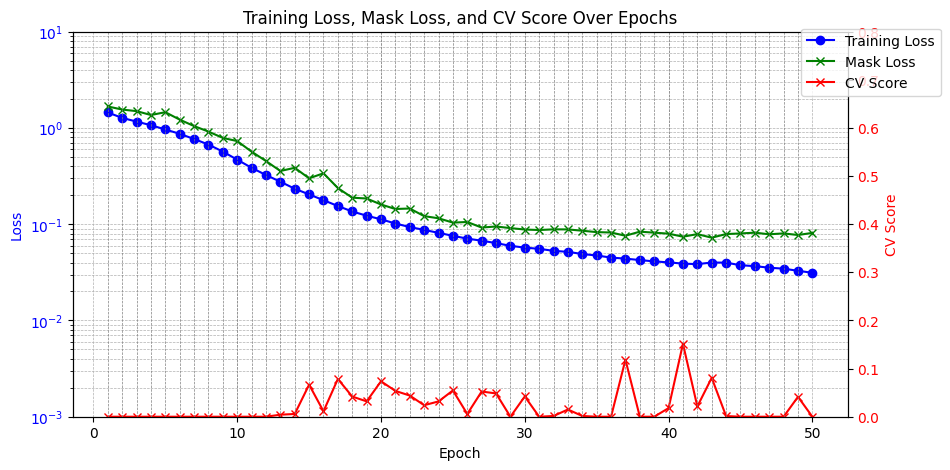

In [12]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# 左側の軸（Training LossとMask Loss）
ax1.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss', color='blue')
ax1.plot(range(1, len(mask_losses) + 1), mask_losses, marker='x', label='Mask Loss', color='green')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_yscale('log')  # 対数スケール（任意）
ax1.set_ylim(0.001, 10) 
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# 右側の軸（CV Score）
ax2 = ax1.twinx()
ax2.plot(range(1, len(cv_scores) + 1), cv_scores, marker='x', label='CV Score', color='red')
ax2.set_ylabel('CV Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 0.8)

# 凡例を追加
fig.legend(loc="upper right", bbox_to_anchor=(1, 0.9))
plt.title('Training Loss, Mask Loss, and CV Score Over Epochs')

#薄い線を追加
for i in range(1, len(epoch_losses)):
    plt.axvline(i, color='gray', linestyle='--', linewidth=0.5)

# グラフ表示
plt.show()

In [13]:
num_epochs = 30
learning_rate = 1e-4
accumulation_steps = 4  # 勾配を累積するステップ数

optimizer = torch.optim.AdamW(
    net.parameters(),
    amsgrad=False,
    betas=(0.9, 0.999),
    capturable=False,
    differentiable=False,
    eps=1e-08,
    foreach=None,
    fused=None,
    lr=learning_rate,
    weight_decay=0.01
)

warmup_steps = 30
total_steps = num_epochs * len(dataloader)

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))  # 線形ウォームアップ
    return 0.5 * (1. + np.cos(np.pi * (current_step - warmup_steps) / (total_steps - warmup_steps)))

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

scaler = torch.cuda.amp.GradScaler(init_scale=4096)
global_step = 0

for epoch in range(num_epochs):
    if False:  # epoch % 5 == 0 を無効化
        optimizer = torch.optim.AdamW(
            net.parameters(),
            amsgrad=False,
            betas=(0.9, 0.999),
            capturable=False,
            differentiable=False,
            eps=1e-08,
            foreach=None,
            fused=None,
            lr=learning_rate,
            weight_decay=0.01
        )

    print(f"エポック {epoch + 1}/{num_epochs}")
    print("-" * 10)

    net.train()
    running_loss = 0.0

    for i, (volumes, masks) in enumerate(dataloader):
        # 1次元削減
        volumes = volumes.squeeze(0)
        masks = masks.squeeze(0)

        batch, D, H, W = volumes.shape

        if np.sum(masks) == 0:
            continue
        batch = {
            'image': volumes.to(device).float(),
            'mask': masks.to(device).long(),
        }

        optimizer.zero_grad(set_to_none=True) if i % accumulation_steps == 0 else None

        with torch.amp.autocast(device_type="cuda", enabled=True):
            output = net(batch)
            loss = output['mask_loss'] / accumulation_steps  # 累積ステップ数でスケーリング

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(dataloader):
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            global_step += 1

        running_loss += loss.item() * accumulation_steps  # スケーリングを戻して加算

    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"train_loss: {epoch_loss:.4f}")
    # 15エポックごとにCVスコアを計算
    if  epoch  % 1 == 0:
        gb, lb_score, mask_loss,probability = evaluate_cv(net, test_id, cfg, valid_dir, device, mask_size2)
        print(f"valid_loss: {np.mean(mask_loss):.4f}")
        print(f"CVスコア {lb_score:.4f}")  # test_id: 検証用データIDリスト
        print(gb[["particle_type", "P", "T", "hit", "precision", "recall", "f-beta4"]])
    cv_scores.append(lb_score)
    #lbスコアが最大のモデルを保存
    if lb_score == max(cv_scores):
        torch.save({'state_dict': net.state_dict()}, '../model/resnet34d.pth')
    mask_losses.append(np.mean(mask_loss))

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


エポック 1/30
----------
train_loss: 0.0306
valid_loss: 0.0681
CVスコア 0.1103
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin  35  82    3   0.085714  0.036585  0.037862
1         beta-amylase  15  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  12  36    0   0.000000  0.000000  0.000000
3             ribosome  95  96   21   0.221053  0.218750  0.218884
4        thyroglobulin  88  79    7   0.079545  0.088608  0.088018
5  virus-like-particle  67  24    9   0.134328  0.375000  0.339246
エポック 2/30
----------
train_loss: 0.0300
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0798
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin  53  36    0        0.0     0.0      0.0
1         beta-amylase   5  21    0        0.0     0.0      0.0
2   beta-galactosidase   1  24    0        0.0     0.0      0.0
3             ribosome   8  65    0        0.0     0.0      0.0
4        thyroglobulin   4  49    0        0.0     0.0      0.0
5  virus-like-particle  14  13    0        0.0     0.0      0.0
エポック 3/30
----------
train_loss: 0.0288
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0696
CVスコア 0.1329
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin  13  36    1   0.076923  0.027778  0.028862
1         beta-amylase   1  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   2  24    0   0.000000  0.000000  0.000000
3             ribosome  55  65   21   0.381818  0.323077  0.326027
4        thyroglobulin  50  49    2   0.040000  0.040816  0.040767
5  virus-like-particle  33  13    7   0.212121  0.538462  0.493776
エポック 4/30
----------
train_loss: 0.0286
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0766
CVスコア 0.0966
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin   9  36    0   0.000000  0.000000  0.000000
1         beta-amylase   1  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   1  24    0   0.000000  0.000000  0.000000
3             ribosome  25  65    8   0.320000  0.123077  0.127700
4        thyroglobulin  14  49    0   0.000000  0.000000  0.000000
5  virus-like-particle   9  13    7   0.777778  0.538462  0.548387
エポック 5/30
----------
train_loss: 0.0280
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0821
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  5  36    0        0.0     0.0      0.0
1         beta-amylase  3  21    0        0.0     0.0      0.0
2   beta-galactosidase  1  24    0        0.0     0.0      0.0
3             ribosome  1  65    0        0.0     0.0      0.0
4        thyroglobulin  2  49    0        0.0     0.0      0.0
5  virus-like-particle  2  13    0        0.0     0.0      0.0
エポック 6/30
----------
train_loss: 0.0279
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0849
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  5  36    0        0.0     0.0      0.0
1         beta-amylase  5  21    0        0.0     0.0      0.0
2   beta-galactosidase  1  24    0        0.0     0.0      0.0
3             ribosome  1  65    0        0.0     0.0      0.0
4        thyroglobulin  1  49    0        0.0     0.0      0.0
5  virus-like-particle  3  13    0        0.0     0.0      0.0
エポック 7/30
----------
train_loss: 0.0274
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0801
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin  38  36    0        0.0     0.0      0.0
1         beta-amylase   4  21    0        0.0     0.0      0.0
2   beta-galactosidase   5  24    0        0.0     0.0      0.0
3             ribosome   2  65    0        0.0     0.0      0.0
4        thyroglobulin   3  49    0        0.0     0.0      0.0
5  virus-like-particle  14  13    0        0.0     0.0      0.0
エポック 8/30
----------
train_loss: 0.0265
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0801
CVスコア 0.0390
         particle_type  P   T  hit  precision    recall   f-beta4
0         apo-ferritin  7  36    0       0.00  0.000000  0.000000
1         beta-amylase  1  21    0       0.00  0.000000  0.000000
2   beta-galactosidase  1  24    0       0.00  0.000000  0.000000
3             ribosome  5  65    2       0.40  0.030769  0.032536
4        thyroglobulin  4  49    0       0.00  0.000000  0.000000
5  virus-like-particle  4  13    3       0.75  0.230769  0.240566
エポック 9/30
----------
train_loss: 0.0260
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0811
CVスコア 0.0552
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin   7  36    0   0.000000  0.000000  0.000000
1         beta-amylase   8  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   4  24    0   0.000000  0.000000  0.000000
3             ribosome   6  65    0   0.000000  0.000000  0.000000
4        thyroglobulin  15  49    0   0.000000  0.000000  0.000000
5  virus-like-particle  12  13    5   0.416667  0.384615  0.386364
エポック 10/30
----------
train_loss: 0.0257
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0820
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin  13  36    0        0.0     0.0      0.0
1         beta-amylase   8  21    0        0.0     0.0      0.0
2   beta-galactosidase   5  24    0        0.0     0.0      0.0
3             ribosome   3  65    0        0.0     0.0      0.0
4        thyroglobulin   5  49    0        0.0     0.0      0.0
5  virus-like-particle  15  13    0        0.0     0.0      0.0
エポック 11/30
----------
train_loss: 0.0250
valid_loss: 0.0794
CVスコア 0.0073
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin  33  82    0   0.000000  0.000000  0.000000
1         beta-amylase  11  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   1  36    0   0.000000  0.000000  0.000000
3             ribosome   7  96    1   0.142857  0.010417  0.011017
4        thyroglobulin   4  79    0   0.000000  0.000000  0.000000
5  virus-like-particle  42  24    1   0.02381

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0800
CVスコア 0.0609
         particle_type  P   T  hit  precision    recall   f-beta4
0         apo-ferritin  5  36    0   0.000000  0.000000  0.000000
1         beta-amylase  2  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase  1  24    0   0.000000  0.000000  0.000000
3             ribosome  3  65    2   0.666667  0.030769  0.032598
4        thyroglobulin  6  49    0   0.000000  0.000000  0.000000
5  virus-like-particle  8  13    5   0.625000  0.384615  0.393519
エポック 14/30
----------
train_loss: 0.0241
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0790
CVスコア 0.0872
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin  12  36    0   0.000000  0.000000  0.000000
1         beta-amylase   3  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   1  24    0   0.000000  0.000000  0.000000
3             ribosome  15  65    4   0.266667  0.061538  0.064455
4        thyroglobulin  12  49    0   0.000000  0.000000  0.000000
5  virus-like-particle  10  13    7   0.700000  0.538462  0.545872
エポック 15/30
----------
train_loss: 0.0234
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0766
CVスコア 0.1165
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin  21  36    5   0.238095  0.138889  0.142379
1         beta-amylase   1  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   0  24    0   0.000000  0.000000  0.000000
3             ribosome  28  65    7   0.250000  0.107692  0.111423
4        thyroglobulin  25  49    1   0.040000  0.020408  0.021014
5  virus-like-particle  21  13    7   0.333333  0.538462  0.519651
エポック 16/30
----------
train_loss: 0.0231
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0691
CVスコア 0.2031
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin  53  36    9   0.169811  0.250000  0.243243
1         beta-amylase   9  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   2  24    0   0.000000  0.000000  0.000000
3             ribosome  88  65   21   0.238636  0.323077  0.316489
4        thyroglobulin  66  49    7   0.106061  0.142857  0.140000
5  virus-like-particle  55  13    9   0.163636  0.692308  0.581749
エポック 17/30
----------
train_loss: 0.0222
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0811
CVスコア 0.0565
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin  13  36    0   0.000000  0.000000  0.000000
1         beta-amylase   4  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   0  24    0   0.000000  0.000000  0.000000
3             ribosome   5  65    0   0.000000  0.000000  0.000000
4        thyroglobulin   6  49    0   0.000000  0.000000  0.000000
5  virus-like-particle   7  13    5   0.714286  0.384615  0.395349
エポック 18/30
----------
train_loss: 0.0220
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0828
CVスコア 0.0151
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  121  36    0   0.000000  0.000000  0.000000
1         beta-amylase   10  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase    0  24    0   0.000000  0.000000  0.000000
3             ribosome    3  65    0   0.000000  0.000000  0.000000
4        thyroglobulin    1  49    0   0.000000  0.000000  0.000000
5  virus-like-particle  113  13    2   0.017699  0.153846  0.105919
エポック 19/30
----------
train_loss: 0.0223
valid_loss: 0.0824
CVスコア 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin  73  82    0        0.0     0.0      0.0
1         beta-amylase   5  31    0        0.0     0.0      0.0
2   beta-galactosidase   0  36    0        0.0     0.0      0.0
3             ribosome  19  96    0        0.0     0.0      0.0
4        thyroglobulin   4  79    0        0.0     0.0      0.0
5  virus-like-particle  73  24    0

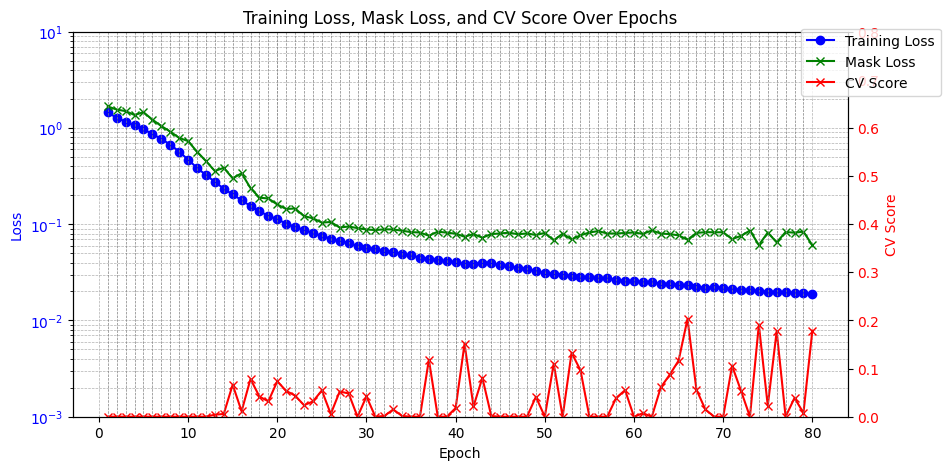

In [14]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# 左側の軸（Training LossとMask Loss）
ax1.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss', color='blue')
ax1.plot(range(1, len(mask_losses) + 1), mask_losses, marker='x', label='Mask Loss', color='green')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_yscale('log')  # 対数スケール（任意）
ax1.set_ylim(0.001, 10) 
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# 右側の軸（CV Score）
ax2 = ax1.twinx()
ax2.plot(range(1, len(cv_scores) + 1), cv_scores, marker='x', label='CV Score', color='red')
ax2.set_ylabel('CV Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 0.8)

# 凡例を追加
fig.legend(loc="upper right", bbox_to_anchor=(1, 0.9))
plt.title('Training Loss, Mask Loss, and CV Score Over Epochs')

#薄い線を追加
for i in range(1, len(epoch_losses)):
    plt.axvline(i, color='gray', linestyle='--', linewidth=0.5)

# グラフ表示
plt.show()

In [15]:
volumes = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.float32)
masks = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.uint8)

n = 0
for idx in range(len(valid_id)):
    for diff_type in diff:
        data = read_diff_data(valid_id[idx], train_dir, diff_type)
        data = data.astype(np.float32)
        volumes[n, :, :, :] = data

        y = read_one_truth(valid_id[idx], f'{valid_dir}/overlay/ExperimentRuns')
        mask_data = generate_mask(y, mask_size2)
        mask_data = mask_data.astype(np.uint8)
        masks[n, :, :, :] = mask_data
        n += 1
print(volumes.shape)
print(masks.shape)

(5, 184, 630, 630)
(5, 184, 630, 630)


Text(0.5, 1.0, 'truth')

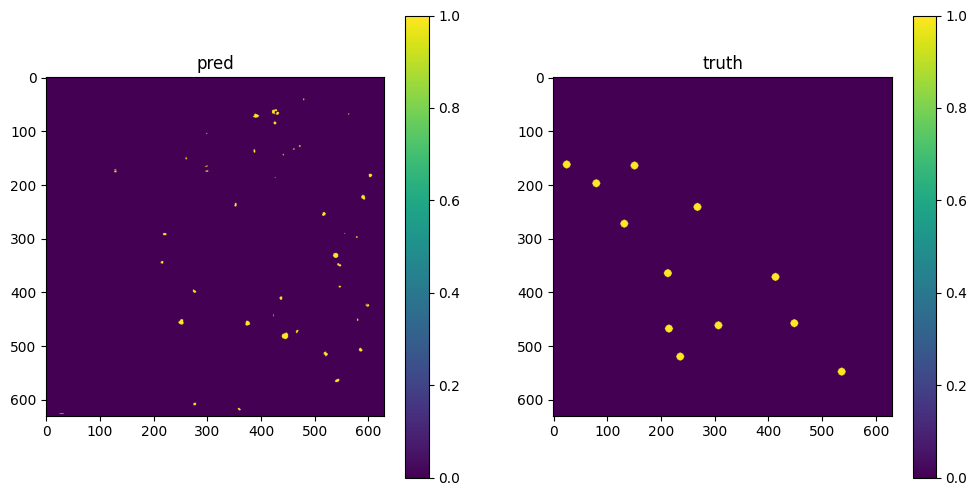

In [18]:
Class =3
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

im1 = axes[0].imshow(probability[Class].max(0)>0.05)
fig.colorbar(im1, ax=axes[0])
axes[0].set_title('pred')

on_hot =np.eye(7)[masks]
im2 = axes[1].imshow(on_hot[0,:,:,:,Class].max(0))
fig.colorbar(im2, ax=axes[1])
axes[1].set_title('truth')